# R: Baudry ML Reserving Pt 1

*This article was originally created by Nigel Carpenter and published in the [General Insurance Machine Learning for Reserving Working Party (“MLR-WP”) blog](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/). The MLR-WP is an international research group on machine learning techniques to reserving, with over 50 actuaries from around the globe. The goal of the group is to bring machine learning techniques into widespread adoption ‘on the ground’ by identifying what the barriers are, communicating any benefits, and helping develop the research techniques in pragmatic ways. Whilst some articles have been brought into this cookbook, consider exploring the [blog](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/) further for additional content including detailed walkthroughs of more advanced models.*

# Introduction

This is the first notebook of a series of three that outlines and elaborates upon code used to replicate the central scenario in the paper of Maximilien Baudry "NON-PARAMETRIC INDIVIDUAL
CLAIM RESERVING IN INSURANCE" ([Presentation](https://www.institutdesactuaires.com/global/gene/link.php?doc_id=11747&fg=1) [Paper](http://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/6b3d579479584e35c12581eb00468777/$FILE/Reserving-article.pdf))

Below we step through the process to create a single simulated dataset, as set out in Section 5 of Baudry's paper. Having stepped through the data creation process, at the end, we present the code in the form of a function that returns a simulated policy and claim dataset. 

The second notebook details the process for creating a reserving database and the third outlines the process for creating reserves using machine learning.

Before we start we import a few pre-requisite R packages.

In [1]:
# Importing packages
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(IRdisplay)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




# Create Policy Data set
We start by simulating number of policies sold by day and by policy coverage type.  

## Policy count by date

In [2]:
# polices sold between start 2016 to end 2017
dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))

# number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
dt_policydates[, ':='(policycount = rpois(.N,700),
                      date_lapse = date_UW %m+% years(1),
                      expodays = as.integer(date_UW %m+% years(1) - date_UW),
                      pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]



##  Policy covers by date 

We then add policy coverage columns in proportions 25% Breakage, 45% Breakage and Oxidation and 30% Breakage, Oxidation and Theft.

In [3]:
# Add columns defining Policy Covers   
dt_policydates[, Cover_B := round(policycount * 0.25)]
dt_policydates[, Cover_BO := round(policycount * 0.45)]
dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]

In [4]:
kable(head(dt_policydates), "html") %>% 
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_UW,policycount,date_lapse,expodays,pol_prefix,Cover_B,Cover_BO,Cover_BOT
2016-01-01,693,2017-01-01,366,20160101,173,312,208
2016-01-02,690,2017-01-02,366,20160102,172,310,208
2016-01-03,716,2017-01-03,366,20160103,179,322,215
2016-01-04,714,2017-01-04,366,20160104,178,321,215
2016-01-05,727,2017-01-05,366,20160105,182,327,218
2016-01-06,763,2017-01-06,366,20160106,191,343,229


## Policy transaction file
We then create a policy transaction file containing 1 row per policy, with columns to indicate policy coverage details.  

### Policy date & number  
The first step is to create a policy table with 1 row per policy and underwriting date. 

In [5]:
# repeat rows for each policy by UW-Date
dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]

# Create a unique policy number 
dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]

kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_UW,pol_prefix,pol_seq,pol_number
2016-01-01,20160101,1,201601010001
2016-01-01,20160101,2,201601010002
2016-01-01,20160101,3,201601010003
2016-01-01,20160101,4,201601010004
2016-01-01,20160101,5,201601010005
2016-01-01,20160101,6,201601010006


### Policy coverage type
Then we add the policy coverage details appropriate to each row.

In [6]:
# set join keys
setkey(dt_policy,'date_UW')
setkey(dt_policydates,'date_UW')  

# remove pol_prefix before join
dt_policydates[, pol_prefix := NULL]  

# join cover from summary file (dt_policydates)
dt_policy <- dt_policy[dt_policydates]  

# now create Cover field for each policy row
dt_policy[,Cover := 'BO']
dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
dt_policy[pol_seq <= Cover_B,Cover := 'B']  

dt_policy[, Cover_B := as.factor(Cover)]  

# remove interim calculation fields
dt_policy[, ':='(pol_prefix = NULL,
                 policycount = NULL,
                 pol_seq = NULL,
                 Cover_B = NULL,
                 Cover_BOT = NULL,
                 Cover_BO = NULL)]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()


date_UW,pol_number,date_lapse,expodays,Cover
2016-01-01,201601010001,2017-01-01,366,B
2016-01-01,201601010002,2017-01-01,366,B
2016-01-01,201601010003,2017-01-01,366,B
2016-01-01,201601010004,2017-01-01,366,B
2016-01-01,201601010005,2017-01-01,366,B
2016-01-01,201601010006,2017-01-01,366,B


### Policy Brand, Price, Model features   
Now further details can be added to the policy dataset; such as policy brand, model and price details.

In [7]:
# Add remaining policy details
dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]

# models types and model cost multipliers
for (eachBrand in unique(dt_policy$Brand)) {
  dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
  dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
}

dt_policy[, Price := ceiling (Base_Price * Model_mult)]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>% 
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_UW,pol_number,date_lapse,expodays,Cover,Brand,Base_Price,Model,Model_mult,Price
2016-01-01,201601010001,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010002,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010003,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010004,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010005,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010006,2017-01-01,366,B,1,600,3,1.520875,913


###  Tidy and save
The final step is to keep only columns of interest and save the resulting policy file.

In [8]:
# colums to keep
cols_policy <- c("pol_number",
                 "date_UW",
                 "date_lapse",
                 "Cover",
                 "Brand",
                 "Model",
                 "Price")

dt_policy <- dt_policy[, cols_policy, with = FALSE]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

save(dt_policy, file = "./dt_policy.rda")

pol_number,date_UW,date_lapse,Cover,Brand,Model,Price
201601010001,2016-01-01,2017-01-01,B,1,3,913
201601010002,2016-01-01,2017-01-01,B,1,3,913
201601010003,2016-01-01,2017-01-01,B,1,3,913
201601010004,2016-01-01,2017-01-01,B,1,3,913
201601010005,2016-01-01,2017-01-01,B,1,3,913
201601010006,2016-01-01,2017-01-01,B,1,3,913


# Create claims file  
## Sample Claims from Policies
We now simulate claims arising from the policy coverages. Claim rates vary by policy coverage and type. 

### Breakage Claims
We start with breakages claims and sample from the policies data set to create claims.

In [9]:
# All policies have breakage cover
# claims uniformly sampled from policies
claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))

# Claim severity multiplier sampled from beta distribution
dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                       claim_type = 'B',
                       claim_count = 1,
                       claim_sev = rbeta(length(claim), 2,5))

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev
201706250197,B,1,0.0066006
201702160566,B,1,0.1305747
201703080185,B,1,0.3325863
201709090113,B,1,0.2690556
201604260297,B,1,0.2531805
201707310143,B,1,0.1357897


### Oxidation Claims

Oxidation claims follow a similar process, just with different incidence rates and severities.

In [10]:
# identify all policies with Oxidation cover
cov <- which(dt_policy$Cover != 'B')

# sample claims from policies with cover
claim <- sample(cov, size = floor(length(cov) * 0.05))

# add claims to table 
dt_claim <- rbind(dt_claim,
                  data.table(pol_number = dt_policy[claim, pol_number],
                             claim_type = 'O',
                             claim_count = 1,
                             claim_sev = rbeta(length(claim), 5,3)))

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev
201706250197,B,1,0.0066006
201702160566,B,1,0.1305747
201703080185,B,1,0.3325863
201709090113,B,1,0.2690556
201604260297,B,1,0.2531805
201707310143,B,1,0.1357897


### Theft Claims 

In the original paper the distribution for Theft severity claims is stated to be Beta(alpha = 5, beta = 0.5). 


In [11]:
# identify all policies with Theft cover
# for Theft claim frequency varies by Brand
# So need to consider each in turn...

for(myModel in 0:3) {

    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
  
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
}

# check output
kable(head(dt_claim), "html") %>% 
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

kable(tail(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev
201706250197,B,1,0.0066006
201702160566,B,1,0.1305747
201703080185,B,1,0.3325863
201709090113,B,1,0.2690556
201604260297,B,1,0.2531805
201707310143,B,1,0.1357897


pol_number,claim_type,claim_count,claim_sev
201708230205,T,1,0.9648917
201701280297,T,1,0.8245351
201701020337,T,1,0.7794176
201605080388,T,1,0.8335502
201608140365,T,1,0.9262032
201710040235,T,1,0.6904011


## Claim dates and costs

### Policy UW_date and value

We now need to add details to claims, such as policy underwritng date and phone cost.
These details come from the policy table.

In [12]:
# set join keys
setkey(dt_policy, pol_number)
setkey(dt_claim, pol_number)

#join Brand and Price from policy to claim
dt_claim[dt_policy,
         on = 'pol_number',
         ':='(date_UW = i.date_UW,
              Price = i.Price,
              Brand = i.Brand)]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev,date_UW,Price,Brand
201601010003,B,1,0.2786004,2016-01-01,913,1
201601010019,B,1,0.3383702,2016-01-01,229,4
201601010021,B,1,0.2924503,2016-01-01,913,1
201601010028,B,1,0.2193067,2016-01-01,794,1
201601010032,B,1,0.2106113,2016-01-01,837,2
201601010047,B,1,0.1108387,2016-01-01,913,1


### Add simulated Claim occrrence, reporting and payment delays   

The occurrence delay is assumed uniform over policy exposure period.
Reporting and payment delays are assumed to follow Beta distributions.

In [13]:
# use lubridate %m+% date addition operator 
dt_claim[, date_lapse := date_UW %m+% years(1)]
dt_claim[, expodays := as.integer(date_lapse - date_UW)]
dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]

dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  

dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
dt_claim[, date_report := date_occur %m+% days(delay_report)]
dt_claim[, date_pay := date_report %m+% days(delay_pay)]

dt_claim[, claim_cost := round(Price * claim_sev)]

In [14]:
# check output
head(dt_claim)

pol_number,claim_type,claim_count,claim_sev,date_UW,Price,Brand,date_lapse,expodays,occ_delay_days,delay_report,delay_pay,date_occur,date_report,date_pay,claim_cost
<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<date>,<int>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<dbl>
201601010003,B,1,0.2786004,2016-01-01,913,1,2017-01-01,366,173,71,28,2016-06-22,2016-09-01,2016-09-29,254
201601010019,B,1,0.3383702,2016-01-01,229,4,2017-01-01,366,139,6,33,2016-05-19,2016-05-25,2016-06-27,77
201601010021,B,1,0.2924503,2016-01-01,913,1,2017-01-01,366,203,2,30,2016-07-22,2016-07-24,2016-08-23,267
201601010028,B,1,0.2193067,2016-01-01,794,1,2017-01-01,366,186,1,29,2016-07-05,2016-07-06,2016-08-04,174
201601010032,B,1,0.2106113,2016-01-01,837,2,2017-01-01,366,199,33,29,2016-07-18,2016-08-20,2016-09-18,176
201601010047,B,1,0.1108387,2016-01-01,913,1,2017-01-01,366,141,0,29,2016-05-21,2016-05-21,2016-06-19,101


###  Claim key and tidy

The final stage is to do some simple tidying and add a unique claim key. The file is then saved for future use.

Note that the original paper spoke of using a "competing hazards model" for simulating claims. I have taken this to mean that a policy can only give rise to one claim. Where the above process has simulated multiple claims against the same policy I keep only the first occurring claim. 



In [15]:
# add a unique claimkey based upon occurence date

dt_claim[, clm_prefix := year(date_occur)*10000 + month(date_occur)*100 + mday(date_occur)]
dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]


# keep only first claim against policy (competing hazards)
setkeyv(dt_claim, c("pol_number", "clm_prefix"))
dt_claim[, polclm_seq := seq_len(.N), by = .(pol_number)]
dt_claim <- dt_claim[polclm_seq == 1,]

# colums to keep
cols_claim <- c("clm_number",
                "pol_number",
                "claim_type",
                "claim_count",
                "claim_sev",
                "date_occur",
                "date_report",
                "date_pay",
                "claim_cost")

dt_claim <- dt_claim[, cols_claim, with = FALSE]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

save(dt_claim, file = "./dt_claim.rda")

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606220001,201601010003,B,1,0.2786004,2016-06-22,2016-09-01,2016-09-29,254
201605190001,201601010019,B,1,0.3383702,2016-05-19,2016-05-25,2016-06-27,77
201607220001,201601010021,B,1,0.2924503,2016-07-22,2016-07-24,2016-08-23,267
201607050001,201601010028,B,1,0.2193067,2016-07-05,2016-07-06,2016-08-04,174
201607180001,201601010032,B,1,0.2106113,2016-07-18,2016-08-20,2016-09-18,176
201605210001,201601010047,B,1,0.1108387,2016-05-21,2016-05-21,2016-06-19,101


# Checking exhibits

Baudry's paper produced a number of summary exhibits from the simulated data. Let's recreate them to get some comfort that we have correctly recreated the data.  

You can see that the severity exhibit, Chart B, is inconsistent with that presented in the original paper. The cause of that difference is unclear at the time of writing. It's likely to be because something nearer to a Beta(alpha = 5, beta = 0.05) has been used. However using that creates other discrepancies likely to be due to issues with the competing hazards implementation.  For now we note the differences and continue with the data as created here.


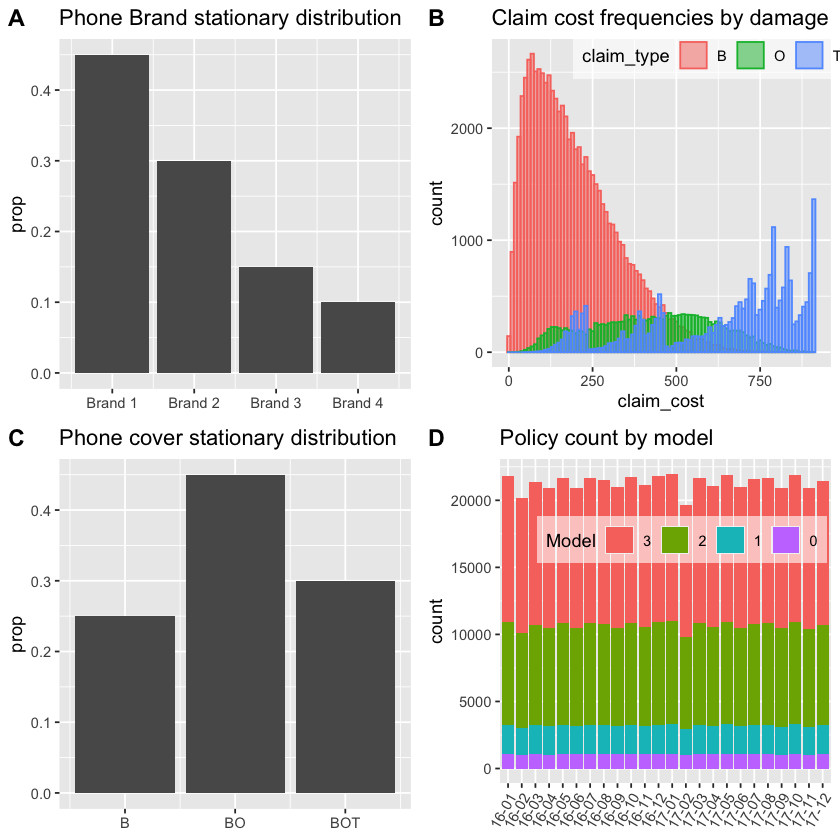

In [16]:
dt_policy[, Cover2 := as.integer(factor(Cover))]

p1 <- ggplot(data = dt_policy, aes(x = Brand, y = ..prop..)) + 
  geom_bar(stat = "count") + 
  labs(title = "Phone Brand stationary distribution", x = NULL) + 
  scale_x_continuous(breaks=c(1,2,3, 4), labels=c("Brand 1", "Brand 2", "Brand 3", "Brand 4"))

p2 <- ggplot(dt_claim, aes(x=claim_cost, fill=claim_type, color=claim_type)) +
  geom_histogram(position="identity", alpha=0.5, binwidth = 10) + 
  labs(title = "Claim cost frequencies by damage") + 
  theme(legend.position = c(.65,.95),
        legend.direction = "horizontal",
        legend.background = element_rect(fill=alpha('white', 0.6)))

p3 <- ggplot(data = dt_policy, aes(x = Cover2, y = ..prop..)) + 
  geom_bar(stat = "count") + 
  labs(title = "Phone cover stationary distribution", x = NULL) + 
  scale_x_continuous(breaks=c(1,2,3), labels=c("B", "BO", "BOT"))

p4 <- ggplot(data = dt_policy, aes(x = format(date_UW, "%y-%m"), fill=factor(Model, levels = c(3,2,1,0)))) + 
  geom_bar(stat = "count") + 
  labs(title = "Policy count by model", x = NULL, fill = "Model") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position = c(.55,.75),
        legend.direction = "horizontal",
        legend.background = element_rect(fill=alpha('white', 0.6)))

plot_grid(p1,p2,p3,p4, labels = "AUTO")

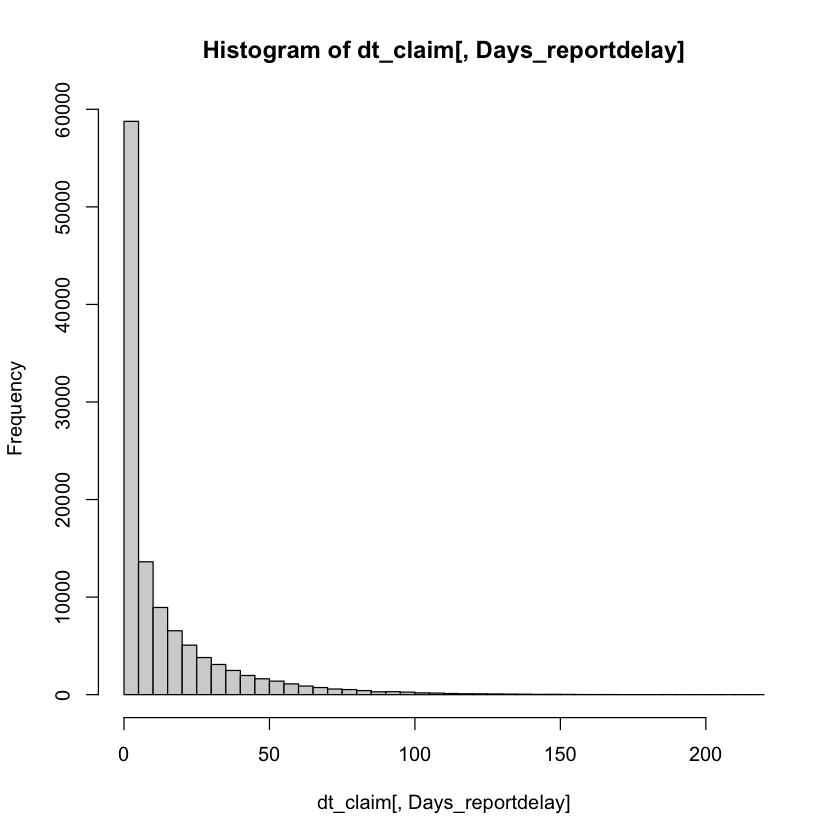

In [17]:

dt_claim[, Days_reportdelay := as.numeric(difftime(date_report, date_occur, units="days"))]


hist(dt_claim[, Days_reportdelay],breaks = 50)


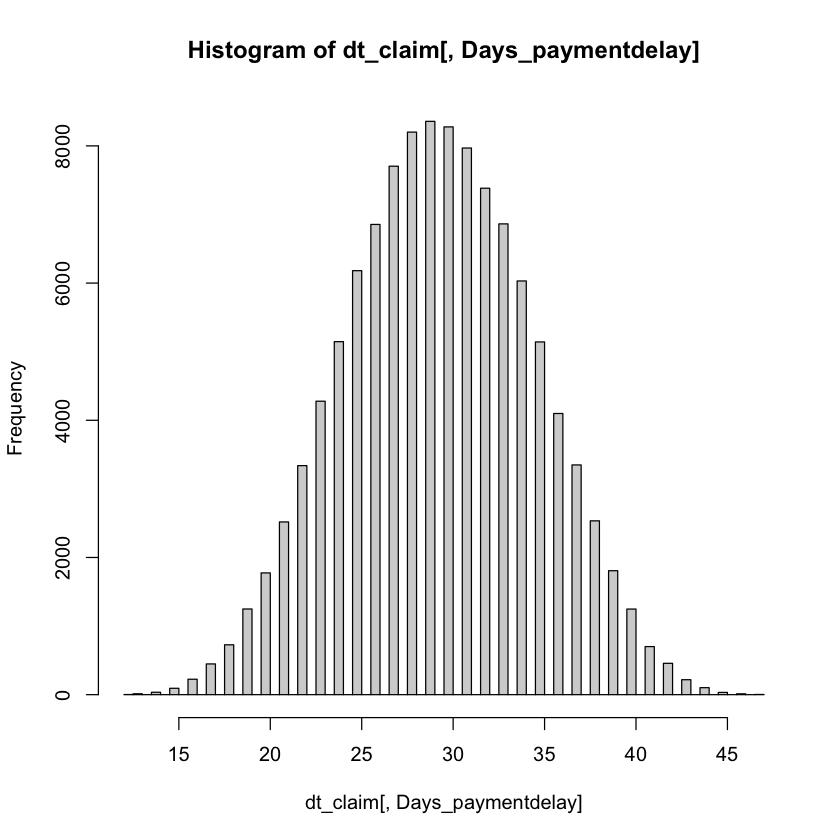

In [18]:
dt_claim[, Days_paymentdelay := as.numeric(difftime(date_pay, date_report, units="days"))]
hist(dt_claim[, Days_paymentdelay],breaks = 60)

The final set of exhibits are those on slide 44. The only difference of note here is in Chart B, the Claim Rate by phone brand. 

Baudry's exhibits show Brand 1 to have a 5% higher claim frequency than other Brands. From reading the paper I can't see why we should expect that to be the case. Claim rate varies by phone Model but Model incidence doesn't vary by Brand. Therefore I can't see how the Chart B equivalent could be correct given the details in the paper. 

I leave the code as is noting the difference but recognising that it will not affect the wider aims of the paper.


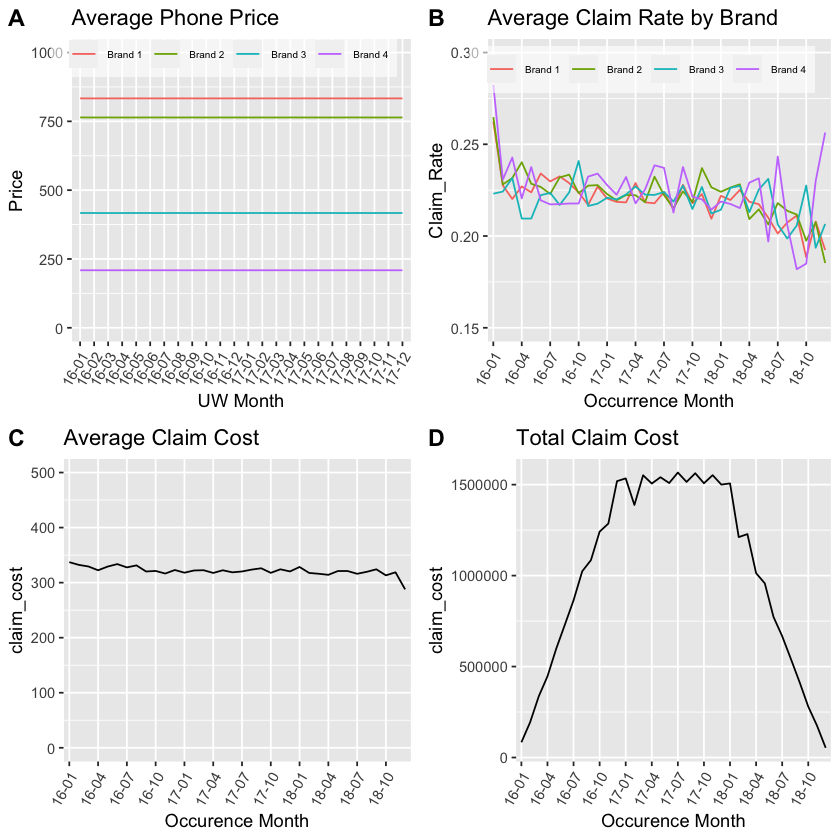

In [19]:
## Exhibits to check output

tmp <- dt_policy[,.(Price = mean(Price)), by = .(Brand = paste0("Brand ", Brand), date_UW=format(date_UW, "%y-%m"))]
p1 <- ggplot(data = tmp, aes(x = date_UW, y = Price, group=factor(Brand))) + 
          geom_line(aes(color = Brand)) + 
          labs(title = "Average Phone Price", x = "UW Month")+
          theme(axis.text.x=element_text(angle=60, hjust=1),
                legend.position = c(.45,.95),
                legend.direction = "horizontal",
                legend.title = element_blank(),
                legend.background = element_rect(fill=alpha('white', 0.6)),
                legend.text = element_text(size = 6)) +
          ylim(0, 1000)

#function to calc policies in force on a date
policy_count <- function(mydate, myBrand){
  dt_policy[date_UW <= mydate & date_lapse >= mydate & Brand == myBrand, .N]
}

#function return every nth axis label
every_nth = function(n) {
  return(function(x) {x[c(TRUE, rep(FALSE, n - 1))]})
}


#create a table to store policy exposures by brand
dt_exposuredates <- NULL
for (eachBrand in unique(dt_policy$Brand)){
  dt_exposuredates <- rbind(dt_exposuredates, data.table(date_Expo = seq(as.Date("2016/1/1"), as.Date("2018/12/31"), "day"),
                                                         Brand = eachBrand))
}

# calculate the exposure
dt_exposuredates[, Expo := mapply(policy_count, date_Expo,Brand)]
# calculate monthly summaries
dt_exposure <- dt_exposuredates[, .(Exposure = sum(Expo)), keyby = .(date_occur=format(date_Expo, "%y-%m"), Brand = paste0("Brand ", Brand)) ]

# add Brand details to Claims details and aggregate to monthly summary
tmp <- dt_policy[dt_claim][,.(claim_cost = sum(claim_cost), claim_count = .N), keyby = .(date_occur=format(date_occur, "%y-%m"), Brand = paste0("Brand ", Brand))]

# add monthly exposures and calculate claim rate
tmp2 <- dt_exposure[tmp][, Claim_Rate := 12 * 30.5 * claim_count / Exposure]

p2 <- ggplot(data = tmp2, aes(x = date_occur, y = Claim_Rate, group=factor(Brand))) + 
  geom_line(aes(color = Brand)) + 
  labs(title = "Average Claim Rate by Brand", x = "Occurrence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position = c(.45,.9),
        legend.direction = "horizontal",
        legend.title = element_blank(),
        legend.background = element_rect(fill=alpha('white', 0.6)),
        legend.text = element_text(size = 6)) +
  scale_x_discrete(breaks = every_nth(n = 3)) +
  ylim(0.15, 0.3)


tmp <- dt_claim[,.(claim_cost = mean(claim_cost)), keyby = .(date_occur=format(date_occur, "%y-%m"))]
p3 <- ggplot(data = tmp, aes(date_occur, claim_cost,  group = 1 )) + 
  geom_line() + 
  labs(title = "Average Claim Cost", x = "Occurence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1))+
  scale_x_discrete(breaks = every_nth(n = 3)) +
  ylim(0, 500)


tmp <- dt_claim[,.(claim_cost = sum(claim_cost)), keyby = .(date_occur=format(date_occur, "%y-%m"))]
p4 <- ggplot(data = tmp, aes(date_occur, claim_cost,  group = 1 )) + 
  geom_line() + 
  labs(title = "Total Claim Cost", x = "Occurence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1)) +
  scale_x_discrete(breaks = every_nth(n = 3)) 


plot_grid(p1,p2,p3,p4, labels = "AUTO")


# Function to create policy and claim data

The above code can be wrapped into a function which returns a list containing the policy and claim datasets.

In [20]:

simulate_central_scenario <- function(seed = 1234){
  
  #seed = 1234  
  set.seed(seed)
  
  # Policy data
  #~~~~~~~~~~~~~~~~~
  
  # polices sold between start 2016 to end 2017
  dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))
  
  # number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
  dt_policydates[, ':='(policycount = rpois(.N,700),
                        date_lapse = date_UW %m+% years(1),
                        expodays = as.integer(date_UW %m+% years(1) - date_UW),
                        pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]
  
  
  # Add columns defining Policy Covers   
  dt_policydates[, Cover_B := round(policycount * 0.25)]
  dt_policydates[, Cover_BO := round(policycount * 0.45)]
  dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]
  
  
  # repeat rows for each policy by UW-Date
  dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]
  
  # Create a unique policy number 
  dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]
  
  # set join keys
  setkey(dt_policy,'date_UW')
  setkey(dt_policydates,'date_UW')  
  
  # remove pol_prefix before join
  dt_policydates[, pol_prefix := NULL]  
  
  # join cover from summary file (dt_policydates)
  dt_policy <- dt_policy[dt_policydates]  
  
  # now create Cover field for each policy row
  dt_policy[,Cover := 'BO']
  dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
  dt_policy[pol_seq <= Cover_B,Cover := 'B']  
  
  # remove interim calculation fields
  dt_policy[, ':='(pol_prefix = NULL,
                   policycount = NULL,
                   pol_seq = NULL,
                   Cover_B = NULL,
                   Cover_BOT = NULL,
                   Cover_BO = NULL)]
  
  # Add remaining policy details
  dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
  dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]
  
  # models types and model cost multipliers
  for (eachBrand in unique(dt_policy$Brand)) {
    dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
    dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
  }
  
  dt_policy[, Price := ceiling (Base_Price * Model_mult)]
  
  
  # colums to keep
  cols_policy <- c("pol_number",
                   "date_UW",
                   "date_lapse",
                   "Cover",
                   "Brand",
                   "Model",
                   "Price")
  
  dt_policy <- dt_policy[, cols_policy, with = FALSE]
  
  # check output
  head(dt_policy)
  
  #save(dt_policy, file = "./dt_policy.rda")
  
  
  # Claims data
  #~~~~~~~~~~~~~~~~~
  
 # All policies have breakage cover
  # claims uniformly sampled from policies
  claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))
  
  # Claim serverity multiplier sampled from beta distn
  dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                         claim_type = 'B',
                         claim_count = 1,
                         claim_sev = rbeta(length(claim), 2,5))
  
  # identify all policies with Oxidation cover
  cov <- which(dt_policy$Cover != 'B')
  
  # sample claims from policies with cover
  claim <- sample(cov, size = floor(length(cov) * 0.05))
  
  # add claims to table 
  dt_claim <- rbind(dt_claim,
                    data.table(pol_number = dt_policy[claim, pol_number],
                               claim_type = 'O',
                               claim_count = 1,
                               claim_sev = rbeta(length(claim), 5,3)))
  
  
  # identify all policies with Theft cover
  # for Theft claim frequency varies by Brand
  # So need to consider each in turn...
  
  for(myModel in 0:3) {
    
    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
    
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
  }
  
  # set join keys
  setkey(dt_policy, pol_number)
  setkey(dt_claim, pol_number)
  
  #join Brand and Price from policy to claim
  dt_claim[dt_policy,
           on = 'pol_number',
           ':='(date_UW = i.date_UW,
                Price = i.Price,
                Brand = i.Brand)]
  
  # use lubridate %m+% date addition operator 
  dt_claim[, date_lapse := date_UW %m+% years(1)]
  dt_claim[, expodays := as.integer(date_lapse - date_UW)]
  dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]
  
  dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
  dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  
  
  dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
  dt_claim[, date_report := date_occur %m+% days(delay_report)]
  dt_claim[, date_pay := date_report %m+% days(delay_pay)]
  
  dt_claim[, claim_cost := round(Price * claim_sev)]
  
  dt_claim[, clm_prefix := year(date_report)*10000 + month(date_report)*100 + mday(date_report)]
  
  dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
  dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]
  
  # colums to keep
  cols_claim <- c("clm_number",
                  "pol_number",
                  "claim_type",
                  "claim_count",
                  "claim_sev",
                  "date_occur",
                  "date_report",
                  "date_pay",
                  "claim_cost")
  
  dt_claim <- dt_claim[, cols_claim, with = FALSE]
  
  output <- list()
  output$dt_policy <- dt_policy
  output$dt_claim <- dt_claim
  
  return(output)
  
  
}

By calling the function with a seed you can simulate policy and claim datasets.

In [21]:
tmp <- simulate_central_scenario(1234)

kable(head(tmp$dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201602190001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254


# Download the code and try it yourself

To finish, if you wish to try out this code in your own local instance of R then we have made this code and the supporting files and folders available in a zip file [here](/mlr-blog/l_baudry/Baudry_1.zip).

Download and extract the zip file to a local directory and then open the R project file `Baudry_1.rproj` in your local R software installation. In the root of the project folder you will see two files;  

1. Notebook_1_SimulateData_v1.Rmd - which is the source code used to recreate this notebook
2. Notebook_1_SimulateData_v1.R - the equivalent code provided as an R script

Please note that, depending upon your R installation , you may have to install R libraries before you can run the code provided. R will warn you if you have missing dependencies and you can then install them from CRAN.